# Notebook for meeting 11/02/2023. 

team airbnb (#28)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt
alt.data_transformers.disable_max_rows()
alt.themes.enable('fivethirtyeight')

import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

# supress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from scipy.stats import ttest_ind

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

import geopandas as gpd
from shapely.geometry import Point

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

## t-test and p-value on before and after the law

In [3]:


# Load the listing data for all the months (use summary version)
data_may_2023 = pd.read_csv('data-listings-summary/listings_summary_202305.csv')
data_june_2023 = pd.read_csv('data-listings-summary/listings_summary_202306.csv')
data_july_2023 = pd.read_csv('data-listings-summary/listings_summary_202307.csv')
data_august_2023 = pd.read_csv('data-listings-summary/listings_summary_202308.csv')
data_september_2023 = pd.read_csv('data-listings-summary/listings_summary_202309.csv')
data_october_2023 = pd.read_csv('data-listings-summary/listings_summary_202310.csv')

# Create a function to compute the metrics
def compute_metrics(data):
    metrics = {
        'count_of_listings': len(data),
        'avg_price': data['price'].mean(),
        'avg_availability_365': data['availability_365'].mean(),
        'avg_reviews_per_month': data['reviews_per_month'].mean()
    }
    return metrics

# Compute the metrics for each month
metrics_may = compute_metrics(data_may_2023)
metrics_june = compute_metrics(data_june_2023)
metrics_july = compute_metrics(data_july_2023)
metrics_august = compute_metrics(data_august_2023)
metrics_september = compute_metrics(data_september_2023)
metrics_october = compute_metrics(data_october_2023)

# Combine the metrics into a DataFrame for easier comparison
metrics_df = pd.DataFrame([metrics_may, metrics_june, metrics_july, metrics_august, 
                           metrics_september, metrics_october], 
                          index=['May', 'June', 'July', 'August', 'September', 'October'])

metrics_df



count_of_listings   avg_price  avg_availability_365  \
May                    43303  216.099577            135.048011   
June                   43566  225.216109            136.998256   
July                   43729  217.068399            138.756272   
August                 43582  212.093640            139.080194   
September              39453  219.153651            144.782146   
October                38792  215.945891            148.752629   

           avg_reviews_per_month  
May                     1.183670  
June                    1.219748  
July                    1.226945  
August                  1.195271  
September               1.137758  
October                 1.078758

In [4]:

# Display the first few rows of the data to get an overview
data_june_2023.head(3)


id                                               name  host_id  \
0   5121  Rental unit in Brooklyn · ★4.52 · 1 bedroom · ...     7356   
1   2595  Rental unit in New York · ★4.68 · Studio · 1 b...     2845   
2  14991  Rental unit in New York · ★4.93 · 1 bedroom · ...    59023   

  host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0     Garon            Brooklyn  Bedford-Stuyvesant  40.68535  -73.95512   
1  Jennifer           Manhattan             Midtown  40.75356  -73.98559   
2    Bianca           Manhattan     Lower East Side  40.72207  -73.98976   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room     60              30                 50  2019-12-02   
1  Entire home/apt    240              30                 49  2022-06-21   
2     Private room    120               5                 22  2023-05-14   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.29                               2                 0   
1               0.30                               3               325   
2               0.14                               1               268   

   number_of_reviews_ltm  license  
0                      0      NaN  
1                      1      NaN  
2                      3      NaN

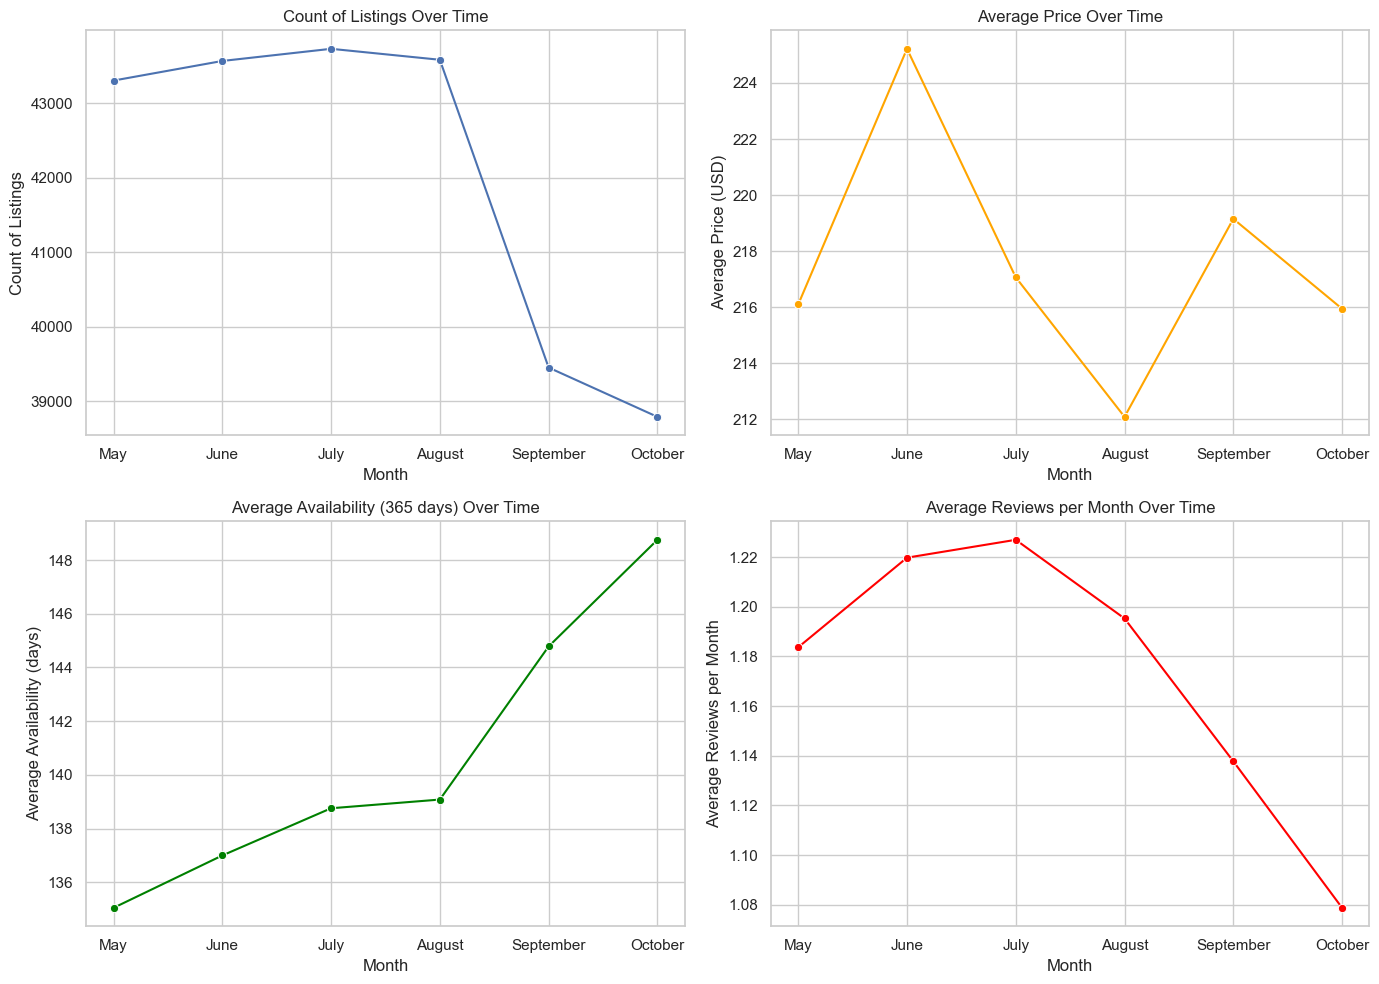

In [5]:


# Set the style for the plots
sns.set(style="whitegrid")

# Plotting the trends for each metric
plt.figure(figsize=(14, 10))

# Count of Listings
plt.subplot(2, 2, 1)
sns.lineplot(data=metrics_df['count_of_listings'], marker='o')
plt.title('Count of Listings Over Time')
plt.xlabel('Month')
plt.ylabel('Count of Listings')

# Average Price
plt.subplot(2, 2, 2)
sns.lineplot(data=metrics_df['avg_price'], marker='o', color='orange')
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price (USD)')

# Average Availability (365 days)
plt.subplot(2, 2, 3)
sns.lineplot(data=metrics_df['avg_availability_365'], marker='o', color='green')
plt.title('Average Availability (365 days) Over Time')
plt.xlabel('Month')
plt.ylabel('Average Availability (days)')

# Average Reviews per Month
plt.subplot(2, 2, 4)
sns.lineplot(data=metrics_df['avg_reviews_per_month'], marker='o', color='red')
plt.title('Average Reviews per Month Over Time')
plt.xlabel('Month')
plt.ylabel('Average Reviews per Month')

plt.tight_layout()
plt.show()


In [6]:
# Splitting the data into before and after the law
before_law = metrics_df.loc[['May', 'June', 'July', 'August']]
after_law = metrics_df.loc[['September', 'October']]

# Function to perform t-test and return p-value
def perform_ttest(before, after):
    t_stat, p_value = ttest_ind(before, after)
    return p_value

# Compute p-values for each metric
p_values = {
    'count_of_listings': perform_ttest(before_law['count_of_listings'], after_law['count_of_listings']),
    'avg_price': perform_ttest(before_law['avg_price'], after_law['avg_price']),
    'avg_availability_365': perform_ttest(before_law['avg_availability_365'], after_law['avg_availability_365']),
    'avg_reviews_per_month': perform_ttest(before_law['avg_reviews_per_month'], after_law['avg_reviews_per_month'])
}

p_values


{'count_of_listings': 5.285452901112105e-05,
 'avg_price': 0.9876865664594411,
 'avg_availability_365': 0.007333004094636687,
 'avg_reviews_per_month': 0.014244929172148747}

p-values from the t-tests comparing the means of the metrics before and after the implementation of Local Law 18:

- Count of Listings: p=0.0005
- Average Price: p=0.98
- Average Availability (365 days): p=0.007
- Average Reviews per Month: p=0.014

Interpretation:

- Count of Listings: The p-value is significantly low, indicating a statistically significant difference in the count of listings before and after the law.

- Average Price: The high p-value suggests that there's no statistically significant difference in average prices before and after the law.

- Average Availability (365 days): The low p-value indicates a statistically significant difference in average availability before and after the law.

- Average Reviews per Month: The p-value is below the common threshold of 0.05, suggesting a statistically significant difference in the average number of reviews per month before and after the law.

These results suggest that the implementation of Local Law 18 has had a statistically significant impact on the count of listings, their availability, and the frequency of reviews. However, it does not seem to have significantly affected the average price of listings.

## neighborhood group / borough

In [16]:

# File paths
file_paths = [
    "data-listings-summary/listings_summary_202305.csv",
    "data-listings-summary/listings_summary_202306.csv",
    "data-listings-summary/listings_summary_202307.csv",
    "data-listings-summary/listings_summary_202308.csv",
    "data-listings-summary/listings_summary_202309.csv",
    "data-listings-summary/listings_summary_202310.csv"
]

# Load the data from each file
dataframes = {}
for path in file_paths:
    month = path.split('_')[-1].split('.')[0]
    dataframes[month] = pd.read_csv(path)


dataframes["202305"].sample(1)


id                                         name  \
18363  808630375571933404  Wyndham Midtown 45 | 1BR/1BA King Bed Suite   

         host_id     host_name neighbourhood_group neighbourhood   latitude  \
18363  442029804  LiveSuite.Io           Manhattan       Midtown  40.751622   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
18363 -73.971969  Entire home/apt    299               1                  0   

      last_review  reviews_per_month  calculated_host_listings_count  \
18363         NaN                NaN                              38   

       availability_365  number_of_reviews_ltm license  
18363               128                      0     NaN

In [21]:
# Extracting the number of listings for each neighbourhood group before and after the law
neighbourhood_groups = dataframes['202305']['neighbourhood_group'].unique()
neighbourhood_group_listings_before = {group: 0 for group in neighbourhood_groups}
neighbourhood_group_listings_after = {group: 0 for group in neighbourhood_groups}

for month in ['202305', '202306', '202307', '202308']:
    for group in neighbourhood_groups:
        neighbourhood_group_listings_before[group] += len(dataframes[month][dataframes[month]['neighbourhood_group'] == group])

for month in ['202309', '202310']:
    for group in neighbourhood_groups:
        neighbourhood_group_listings_after[group] += len(dataframes[month][dataframes[month]['neighbourhood_group'] == group])

# Normalize the counts by the number of months
neighbourhood_group_listings_before = {group: count / 4 for group, count in neighbourhood_group_listings_before.items()}
neighbourhood_group_listings_after = {group: count / 2 for group, count in neighbourhood_group_listings_after.items()}

# neighbourhood_group_listings_before, neighbourhood_group_listings_after

# Create an empty DataFrame with columns for neighbourhood group, listings before, listings after, and change
columns = ['Neighbourhood Group', 'Listings Before', 'Listings After', 'Change']
comparison_df = pd.DataFrame(columns=columns)

# Create a list of dictionaries to store data for each neighborhood group
data_list = []

# Iterate through each neighborhood group and add a dictionary to the list
for group in neighbourhood_groups:
    before = neighbourhood_group_listings_before[group]
    after = neighbourhood_group_listings_after[group]
    change = after - before  # calculate the change in listings
    percentage = (change / before) * 100
    data_list.append({
        'Neighbourhood Group': group,
        'Listings Before': before,
        'Listings After': after,
        'Change': change,
        'Percentage Change': percentage
    })

# Create the DataFrame from the list of dictionaries
comparison_df = pd.DataFrame(data_list)

# Sort the DataFrame based on the 'Change' column to see which neighborhood groups were most affected
comparison_df.sort_values(by='Change', inplace=True)

# Display the DataFrame
comparison_df



Neighbourhood Group  Listings Before  Listings After   Change  \
0            Brooklyn         16345.00         14331.0 -2014.00   
4           Manhattan         18123.50         16949.0 -1174.50   
1              Queens          6956.75          6047.5  -909.25   
2               Bronx          1691.00          1413.5  -277.50   
3       Staten Island           428.75           381.5   -47.25   

   Percentage Change  
0         -12.321811  
4          -6.480536  
1         -13.070040  
2         -16.410408  
3         -11.020408

All boroughs experienced a decrease in the number of listings after the law's implementation, 
with Manhattan and Brooklyn showing the largest reductions. Bronx experienced the largest percentage decrease in listings, while Brooklyn experienced the largest absolute decrease in listings.
This suggests that the law had a widespread impact across the city, affecting listings in all boroughs

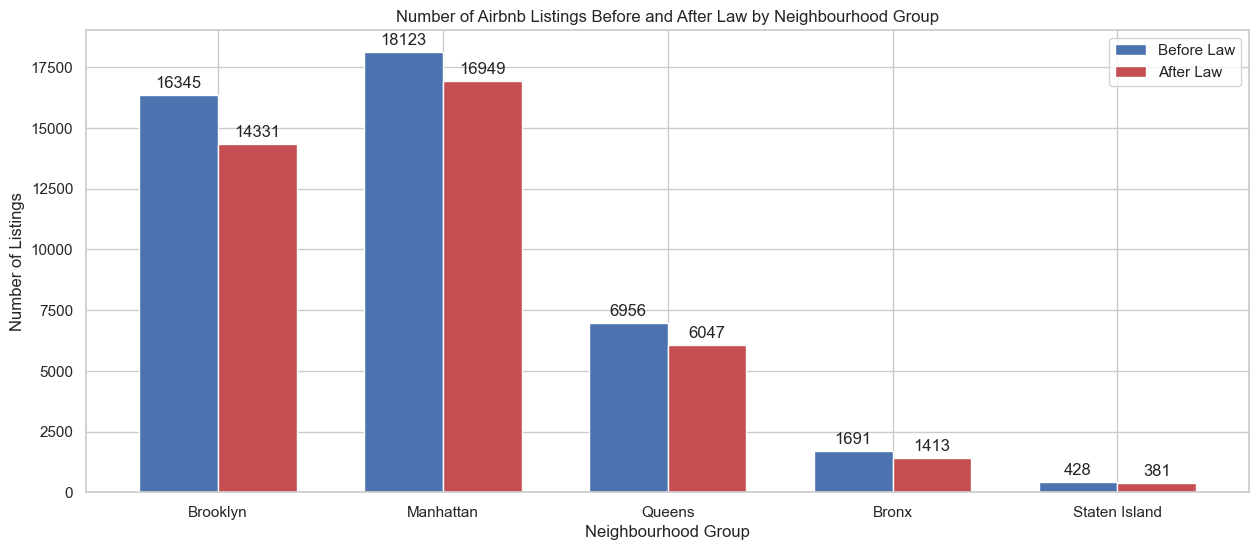

In [22]:
sns.set_style("whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# The x locations for the groups
ind = range(len(comparison_df))

# Width of the bars
bar_width = 0.35

# Plotting the 'Listings Before' bars
before_bars = plt.bar(ind, comparison_df['Listings Before'], bar_width,
                      label='Before Law', color='b', edgecolor='w')

# Plotting the 'Listings After' bars
after_bars = plt.bar([i + bar_width for i in ind], comparison_df['Listings After'], bar_width,
                     label='After Law', color='r', edgecolor='w')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Neighbourhood Group')
ax.set_ylabel('Number of Listings')
ax.set_title('Number of Airbnb Listings Before and After Law by Neighbourhood Group')
ax.set_xticks([i + bar_width / 2 for i in ind])
ax.set_xticklabels(comparison_df['Neighbourhood Group'])
ax.legend()

# Adding labels above the bars to show the exact number
for bar in before_bars + after_bars:
    height = bar.get_height()
    ax.annotate('{}'.format(int(height)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the figure
plt.show()


cluster neighbourhood

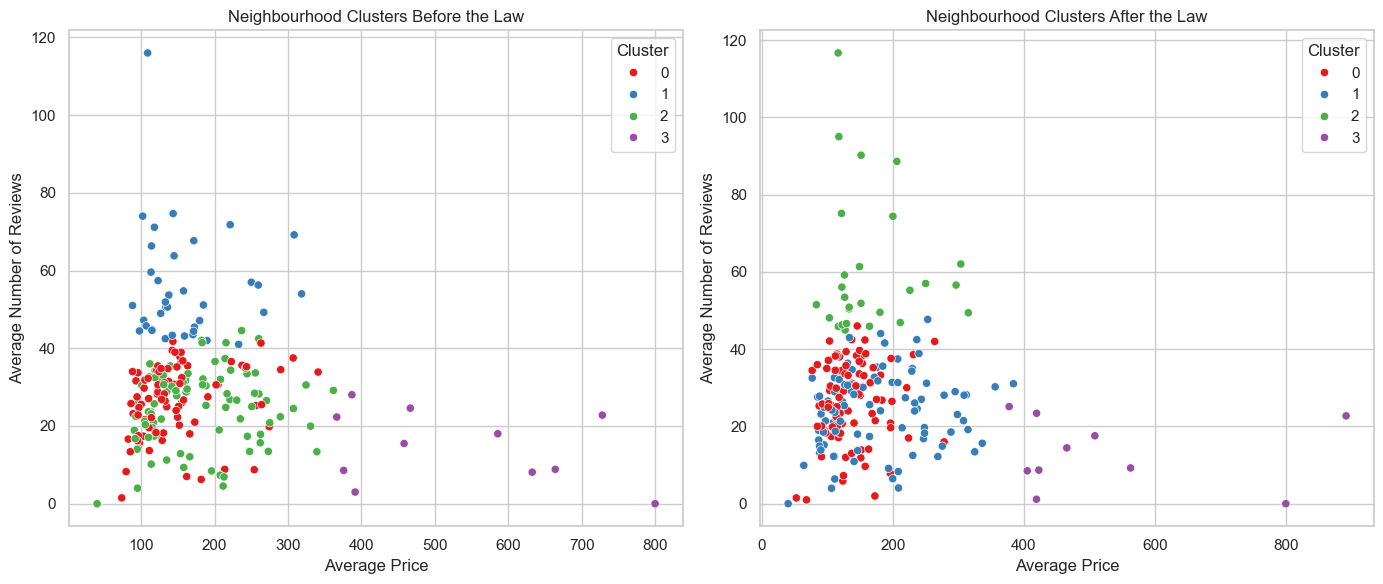

In [23]:



# Prepare data for clustering
cluster_data_before = dataframes['202308'].groupby('neighbourhood').agg({
    'price': 'mean',
    'number_of_reviews': 'mean',
    'availability_365': 'mean'
}).reset_index()

cluster_data_after = dataframes['202310'].groupby('neighbourhood').agg({
    'price': 'mean',
    'number_of_reviews': 'mean',
    'availability_365': 'mean'
}).reset_index()

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_data_before = scaler.fit_transform(cluster_data_before[['price', 'number_of_reviews', 'availability_365']])
scaled_data_after = scaler.transform(cluster_data_after[['price', 'number_of_reviews', 'availability_365']])

# Applying K-Means clustering
kmeans_before = KMeans(n_clusters=4, random_state=42).fit(scaled_data_before)
kmeans_after = KMeans(n_clusters=4, random_state=42).fit(scaled_data_after)

# Adding cluster labels to the original data
cluster_data_before['Cluster'] = kmeans_before.labels_
cluster_data_after['Cluster'] = kmeans_after.labels_

# Visualizing the clusters
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=cluster_data_before, x='price', y='number_of_reviews', hue='Cluster', palette='Set1')
plt.title('Neighbourhood Clusters Before the Law')
plt.xlabel('Average Price')
plt.ylabel('Average Number of Reviews')

plt.subplot(1, 2, 2)
sns.scatterplot(data=cluster_data_after, x='price', y='number_of_reviews', hue='Cluster', palette='Set1')
plt.title('Neighbourhood Clusters After the Law')
plt.xlabel('Average Price')
plt.ylabel('Average Number of Reviews')

plt.tight_layout()
plt.show()





Neighbourhood Clusters Before the Law:

Cluster 0 (Red): Contains the majority of the neighbourhoods. These are neighbourhoods with moderate average prices (around 100-300) and moderate average numbers of reviews (around 0-40). This might represent standard or typical listings in the city.

Cluster 1 (Blue): Features neighbourhoods with moderate to high average prices (around 100-300) but high average numbers of reviews (around 40-120). These could be popular, high-demand neighbourhoods receive a lot of feedback.

Cluster 2 (Green): Comprises neighbourhoods with moderate average prices (around 50-400) but with a higher average number of reviews (around 0-40) compared to Cluster 0. These might be more active or popular areas compared to the ones in Cluster 0.

Cluster 3 (Purple): Has very few neighbourhoods with very high average prices (over 500) but with a moderate number of reviews. These could represent ultra-luxury or niche listings in specific upscale neighbourhoods.


Neighbourhood Clusters After the Law:

Cluster 0 (Red): Has slightly condense in distribution. This cluster represents neighbourhoods with moderate average prices and reviews, suggesting that the typical listings might have become more affordable after the law.

Cluster 1 (Blue): This cluster seems to have disappeared after the law, suggesting that the popular neighbourhoods with a high average number of reviews have seen significant changes. The law might have affected these listings or neighbourhoods the most.

Cluster 2 (Green): Features neighbourhoods with moderate average prices but higher average reviews. It appears to have shifted up. 

Cluster 3 (Purple): Similar to before, this cluster contains very few neighbourhoods with high average prices. However, after the law, the average number of reviews seems to have decreased, indicating that these ultra-luxury areas might have become less active or popular.
General Observations:


Most clusters have experienced a decline in the average number of reviews, suggesting that there might be less activity after the law.

Conclusion: The law seems to have had a considerable impact on the Airbnb landscape. 

## some more stats

In [39]:
# Load all the datasets (detail version)
filepaths = [
    'data-listings-detailed/listings_detailed_202305.csv',
    'data-listings-detailed/listings_detailed_202306.csv',
    'data-listings-detailed/listings_detailed_202307.csv',
    'data-listings-detailed/listings_detailed_202308.csv',
    'data-listings-detailed/listings_detailed_202309.csv',
    'data-listings-detailed/listings_detailed_202310.csv'
]

months = ['May', 'June', 'July', 'August', 'September', 'October']
datasets = {month: pd.read_csv(filepath) for month, filepath in zip(months, filepaths)}

# Check the number of listings for each month
num_listings = {month: len(data) for month, data in datasets.items()}
num_listings


{'May': 43303,
 'June': 43566,
 'July': 43729,
 'August': 43582,
 'September': 39453,
 'October': 38792}

In [40]:
# Extract relevant statistics for each month
stats = {
    'Average Price': [],
    'Availability (30 days)': [],
    'Availability (60 days)': [],
    'Availability (90 days)': [],
    'Average Review Score': []
}

for month, data in datasets.items():
    stats['Average Price'].append(data['price'].str.replace("$", "").str.replace(",", "").astype(float).mean())
    stats['Availability (30 days)'].append(data['availability_30'].mean())
    stats['Availability (60 days)'].append(data['availability_60'].mean())
    stats['Availability (90 days)'].append(data['availability_90'].mean())
    stats['Average Review Score'].append(data['review_scores_rating'].mean())

stats_df = pd.DataFrame(stats, index=months)

# round the values to 2 decimal places
stats_df = stats_df.round(2)

stats_df


Average Price  Availability (30 days)  Availability (60 days)  \
May               216.10                    7.01                   17.04   
June              225.22                    6.89                   17.18   
July              217.07                    7.57                   18.92   
August            212.09                    8.17                   18.10   
September         219.15                    6.92                   17.22   
October           215.95                    7.44                   19.22   

           Availability (90 days)  Average Review Score  
May                         28.77                  4.63  
June                        29.67                  4.64  
July                        30.88                  4.64  
August                      29.83                  4.64  
September                   30.30                  4.63  
October                     32.85                  4.63

In [41]:
# Extract the distribution of property types for each month
property_type_stats = {}

for month, data in datasets.items():
    property_type_stats[month] = data['room_type'].value_counts(normalize=True) * 100

property_type_df = pd.DataFrame(property_type_stats).fillna(0)

# round the values to 2 decimal places

property_type_df = property_type_df.round(2)

property_type_df


May   June   July  August  September  October
room_type                                                       
Entire home/apt  56.66  56.58  56.53   56.56      55.71    54.96
Private room     41.61  41.74  41.87   41.90      42.69    43.43
Shared room       1.31   1.33   1.25    1.24       1.26     1.27
Hotel room        0.42   0.35   0.34    0.31       0.34     0.34

The data suggests that the law's impact on the types of properties listed is not particularly pronounced. 

There is a slight shift towards more private rooms in October, but the changes are relatively modest.

In [42]:
# Extract the number of new listings for each month based on the `first_review` date
new_listings_count = {}

for month, data in datasets.items():
    # Filter listings where the `first_review` date falls within that month
    start_date = f"2023-{str(months.index(month) + 5).zfill(2)}-01"
    end_date = f"2023-{str(months.index(month) + 6).zfill(2)}-01" if month != "October" else "2023-11-01"
    new_listings = data[(data['first_review'] >= start_date) & (data['first_review'] < end_date)]
    new_listings_count[month] = len(new_listings)

new_listings_count


{'May': 50,
 'June': 45,
 'July': 17,
 'August': 27,
 'September': 54,
 'October': 12}

In [43]:
# Check if the 'license' column is mostly null or has meaningful data
license_info = {}

for month, data in datasets.items():
    total_listings = len(data)
    with_license = len(data[data['license'].notna()])
    license_info[month] = {
        'Total Listings': total_listings,
        'With License': with_license,
        'Percentage With License': (with_license / total_listings) * 100
    }

license_df = pd.DataFrame(license_info).T

# round the values to 2 decimal places
license_df = license_df.round(2)

license_df


Total Listings  With License  Percentage With License
May               43303.0           1.0                     0.00
June              43566.0           0.0                     0.00
July              43729.0           0.0                     0.00
August            43582.0           0.0                     0.00
September         39453.0           0.0                     0.00
October           38792.0        2939.0                     7.58

In [44]:
# Extract the distribution of listings by neighborhood for each month
neighborhood_stats = {}

for month, data in datasets.items():
    neighborhood_counts = data['neighbourhood_cleansed'].value_counts(normalize=True) * 100
    neighborhood_stats[month] = neighborhood_counts

neighborhood_df = pd.DataFrame(neighborhood_stats).fillna(0)

# round the values to 2 decimal places
neighborhood_df = neighborhood_df.round(2)

neighborhood_df


May  June  July  August  September  October
neighbourhood_cleansed                                              
Allerton                0.12  0.12  0.12    0.12       0.13     0.12
Arden Heights           0.01  0.01  0.01    0.01       0.02     0.02
Arrochar                0.04  0.04  0.04    0.03       0.04     0.03
Arverne                 0.27  0.28  0.28    0.28       0.27     0.25
Astoria                 1.68  1.71  1.70    1.70       1.57     1.61
...                      ...   ...   ...     ...        ...      ...
Windsor Terrace         0.24  0.25  0.25    0.24       0.24     0.24
Woodhaven               0.23  0.22  0.22    0.22       0.20     0.20
Woodlawn                0.03  0.03  0.03    0.03       0.03     0.03
Woodrow                 0.00  0.01  0.01    0.00       0.01     0.01
Woodside                0.88  0.90  0.90    0.95       0.98     1.05

[223 rows x 6 columns]

In [45]:
# Extract average price by neighborhood for each month
price_by_neighborhood = {}

for month, data in datasets.items():
    # Clean the price column
    data['price'] = data['price'].str.replace("$", "").str.replace(",", "").astype(float)
    
    # Calculate average price by neighborhood
    average_price = data.groupby('neighbourhood_cleansed')['price'].mean()
    price_by_neighborhood[month] = average_price

price_neighborhood_df = pd.DataFrame(price_by_neighborhood).fillna(0)

# round the values to 2 decimal places

price_neighborhood_df = price_neighborhood_df.round(2)


price_neighborhood_df.head()  


May    June    July  August  September  October
neighbourhood_cleansed                                                    
Allerton                129.50  134.92  138.18  137.64     133.33   126.35
Arden Heights           119.50  129.00  135.00  124.67     129.33   127.83
Arrochar                127.88  133.00  131.88  122.00     123.79   137.77
Arverne                 206.09  208.45  254.48  237.26     233.02   221.11
Astoria                 117.33  121.24  120.17  118.92     115.96   115.74

In [46]:
# Extract average availability (30 days) by neighborhood for each month
availability_by_neighborhood = {}

for month, data in datasets.items():
    # Calculate average availability (30 days) by neighborhood
    average_availability = data.groupby('neighbourhood_cleansed')['availability_30'].mean()
    availability_by_neighborhood[month] = average_availability

availability_neighborhood_df = pd.DataFrame(availability_by_neighborhood).fillna(0)

# round the values to 2 decimal places
availability_neighborhood_df = availability_neighborhood_df.round(2)

availability_neighborhood_df.head()  


May   June   July  August  September  October
neighbourhood_cleansed                                                 
Allerton                15.21  13.76  12.22   14.15      14.02    15.89
Arden Heights            4.67   9.50  10.17   16.00      16.33    11.17
Arrochar                 7.94  11.31   9.82   11.29      14.07    16.31
Arverne                 12.19  11.83  12.29   12.77      16.69    15.03
Astoria                  4.73   5.25   6.24    6.24       5.28     6.77

In [47]:
# Extract the number of listings for each borough for each month
borough_stats = {}

for month, data in datasets.items():
    borough_counts = data['neighbourhood_group_cleansed'].value_counts()
    borough_stats[month] = borough_counts

borough_df = pd.DataFrame(borough_stats).fillna(0)
borough_df


May   June   July  August  September  October
neighbourhood_group_cleansed                                                 
Manhattan                     18040  18107  18203   18144      16993    16905
Brooklyn                      16255  16343  16433   16349      14470    14192
Queens                         6891   6972   6971    6993       6146     5949
Bronx                          1700   1711   1681    1672       1453     1374
Staten Island                   417    433    441     424        391      372

In [48]:
# Extract average price for each borough for each month
price_by_borough = {}

for month, data in datasets.items():
    average_price = data.groupby('neighbourhood_group_cleansed')['price'].mean()
    price_by_borough[month] = average_price

price_borough_df = pd.DataFrame(price_by_borough).fillna(0)

# round the values to 2 decimal places
price_borough_df = price_borough_df.round(2)

price_borough_df


May    June    July  August  September  \
neighbourhood_group_cleansed                                              
Bronx                         123.68  126.87  132.11  134.64     133.13   
Brooklyn                      168.71  175.68  176.16  161.30     161.58   
Manhattan                     291.76  307.32  289.82  295.69     306.99   
Queens                        148.06  148.42  139.53  136.86     137.43   
Staten Island                 291.07  286.74  287.98  139.65     136.45   

                              October  
neighbourhood_group_cleansed           
Bronx                          126.12  
Brooklyn                       158.75  
Manhattan                      302.44  
Queens                         132.64  
Staten Island                  131.35

In [49]:
# Extract average availability (30 days) for each borough for each month
availability_by_borough = {}

for month, data in datasets.items():
    average_availability = data.groupby('neighbourhood_group_cleansed')['availability_30'].mean()
    availability_by_borough[month] = average_availability

availability_borough_df = pd.DataFrame(availability_by_borough).fillna(0)

# round the values to 2 decimal places

availability_borough_df = availability_borough_df.round(2)

availability_borough_df


May   June   July  August  September  October
neighbourhood_group_cleansed                                                 
Bronx                         11.62  11.50  11.92   11.95      12.45    14.16
Brooklyn                       5.71   5.97   6.88    7.04       5.74     6.52
Manhattan                      6.68   6.13   6.76    8.16       6.25     6.19
Queens                         9.59   9.60   9.96    9.75       9.81    11.06
Staten Island                 10.84  11.62  12.00   11.31      14.10    16.15

In [50]:
# Extract the distribution of room types for each borough for each month
room_type_by_borough = {}

for month, data in datasets.items():
    room_type_distribution = data.groupby('neighbourhood_group_cleansed')['room_type'].value_counts(normalize=True) * 100
    room_type_by_borough[month] = room_type_distribution

room_type_borough_df = pd.DataFrame(room_type_by_borough).fillna(0)

# round the values to 2 decimal places

room_type_borough_df = room_type_borough_df.round(2)

# Display the DataFrame
room_type_borough_df


May   June   July  August  \
neighbourhood_group_cleansed room_type                                      
Bronx                        Entire home/apt  45.76  45.88  46.46   45.69   
                             Hotel room        0.06   0.06   0.06    0.00   
                             Private room     51.35  51.61  52.35   52.93   
                             Shared room       2.82   2.45   1.13    1.38   
Brooklyn                     Entire home/apt  54.84  54.43  54.38   54.14   
                             Hotel room        0.04   0.04   0.03    0.03   
                             Private room     43.96  44.34  44.38   44.62   
                             Shared room       1.16   1.19   1.21    1.20   
Manhattan                    Entire home/apt  63.79  63.99  63.84   64.11   
                             Hotel room        0.91   0.76   0.75    0.68   
                             Private room     34.24  34.14  34.30   34.17   
                             Shared room       1.06   1.12   1.12    1.04   
Queens                       Entire home/apt  44.84  44.84  44.89   44.92   
                             Hotel room        0.12   0.10   0.10    0.10   
                             Private room     53.08  53.08  53.25   53.18   
                             Shared room       1.96   1.98   1.76    1.80   
Staten Island                Entire home/apt  59.23  59.12  58.05   61.32   
                             Private room     40.05  40.18  41.04   37.74   
                             Shared room       0.72   0.69   0.91    0.94   

                                              September  October  
neighbourhood_group_cleansed room_type                            
Bronx                        Entire home/apt      43.22    41.48  
                             Hotel room            0.00     0.00  
                             Private room         55.33    57.06  
                             Shared room           1.45     1.46  
Brooklyn                     Entire home/apt      52.27    51.14  
                             Hotel room            0.03     0.04  
                             Private room         46.39    47.46  
                             Shared room           1.31     1.37  
Manhattan                    Entire home/apt      64.34    64.27  
                             Hotel room            0.71     0.71  
                             Private room         33.93    34.02  
                             Shared room           1.02     1.00  
Queens                       Entire home/apt      42.68    40.71  
                             Hotel room            0.11     0.12  
                             Private room         55.45    57.42  
                             Shared room           1.76     1.75  
Staten Island                Entire home/apt      59.85    54.84  
                             Private room         38.87    43.82  
                             Shared room           1.28     1.34

## heatmap of listings

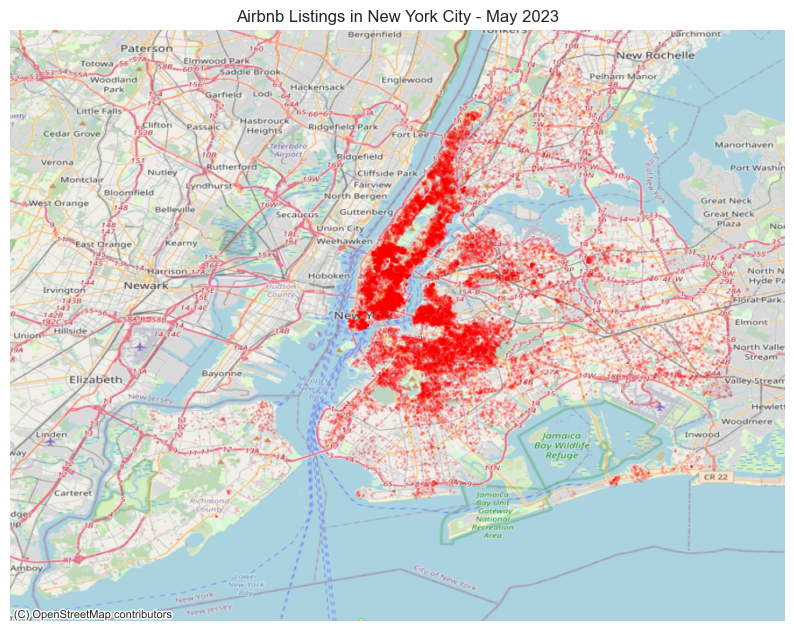

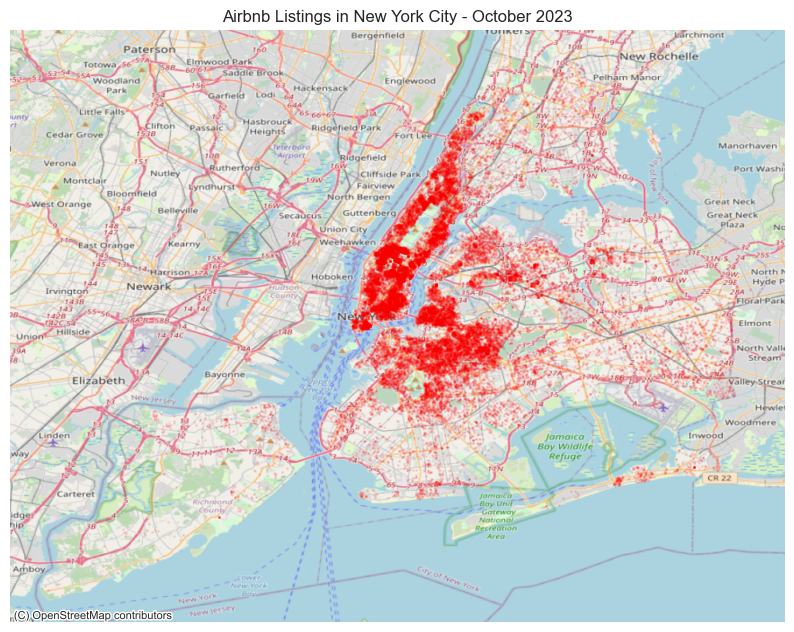

In [51]:


def plot_heatmap(data, month):
    """
    Plot a heatmap of Airbnb listings for a given month.
    """
    # Specify the CRS for your GeoDataFrame, for example, EPSG:4326 (WGS 84)
    crs = 'EPSG:4326'
    
    # Convert DataFrame to GeoDataFrame and set the CRS
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs=crs)
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(ax=ax, markersize=1, color='red', alpha=0.1, label='Listings')
    
    # Use a valid contextily provider (e.g., 'OpenStreetMap.Mapnik')
    ctx.add_basemap(ax, crs=crs, source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.set_title(f'Airbnb Listings in New York City - {month} 2023')
    ax.set_axis_off()

    return fig

# Plot heatmaps for May and October as examples
heatmap_may = plot_heatmap(datasets['May'], 'May')
heatmap_october = plot_heatmap(datasets['October'], 'October')


heatmaps for Airbnb listings in New York City for May and October 2023 as a visual representation of the geographical distribution of listings example.

Density of Listings: In both maps, the majority of Airbnb listings are concentrated in Manhattan, followed by areas in Brooklyn close to Manhattan. There's also a noticeable density in areas of Queens close to Manhattan, such as Long Island City.

Changes Over Time:
In May 2023, we observe higher densities of listings throughout Manhattan, especially in the Midtown, Downtown, and Upper East Side areas.

By October 2023, while the general distribution remains somewhat consistent, there seems to be a slight reduction in the density of listings in parts of Manhattan. This might indicate that some hosts either stopped listing their properties on Airbnb or there were fewer new listings being added in these areas.

Potential Reasons for Changes:

Seasonal Variations: The summer months, including May, are typically peak travel times in New York City. This could explain the higher density in May. By October, tourist activity might slow down a bit leading to fewer listings.

Policy or Regulatory Changes: regulatory changes 

Economic Factors: Economic conditions, such as rent or property prices, can influence a host's decision to list or delist on Airbnb.


In conclusion, while the overall distribution of Airbnb listings in NYC between May and October 2023 remains somewhat consistent, there are subtle changes, especially in the densest areas like Manhattan. These changes could be due to various factors, including seasonal variations, economic conditions, or changes in local regulations.

## Geospacial Average Price

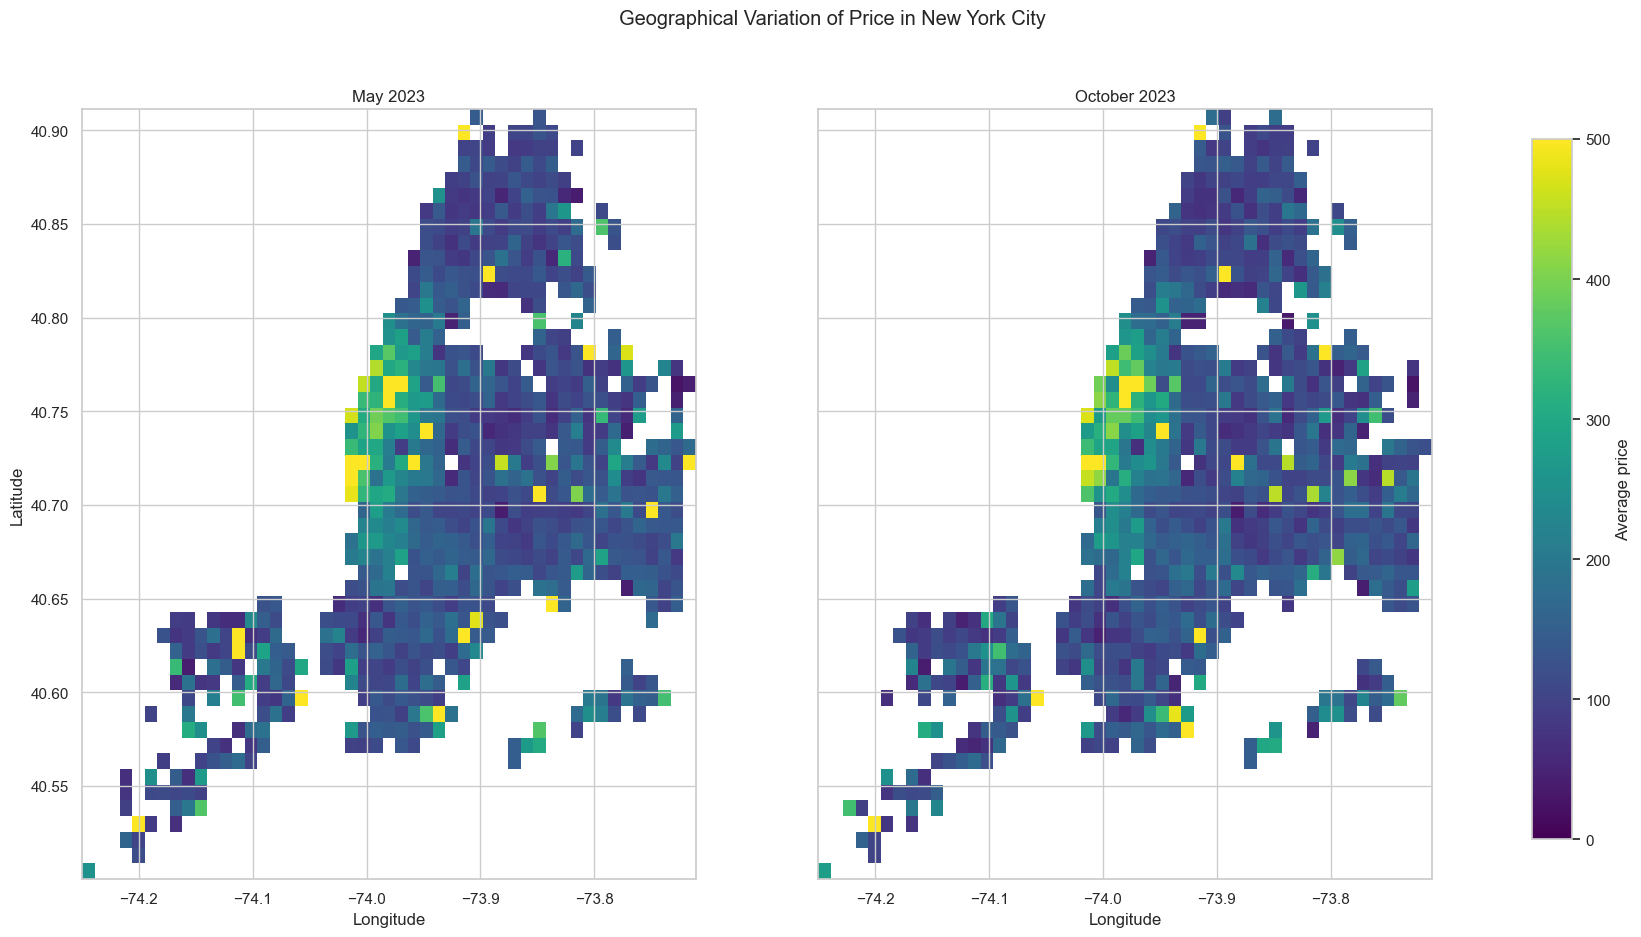

In [52]:


def geographical_variation(data, months, metric="price", n_bins=50):
    """
    Compute and visualize the geographical variation of a given metric side by side for multiple months.
    """
    # Define grid boundaries
    x_min, x_max = data[months[0]]['longitude'].min(), data[months[0]]['longitude'].max()
    y_min, y_max = data[months[0]]['latitude'].min(), data[months[0]]['latitude'].max()

    # Create grid
    x_bins = np.linspace(x_min, x_max, n_bins)
    y_bins = np.linspace(y_min, y_max, n_bins)

    # Define figure and axes for side by side comparison
    fig, axes = plt.subplots(1, len(months), figsize=(20, 10), sharey=True)

    # Determine global min and max for consistent color scale
    # global_min = min([data[month][metric].min() for month in months])
    # global_max = max([data[month][metric].max() for month in months])

    # Specify consistent color scale
    color_scale_min = 0
    color_scale_max = 500

    for ax, month in zip(axes, months):
        # Compute metric for each grid cell
        grid = np.zeros((n_bins-1, n_bins-1))
        for i in range(n_bins-1):
            for j in range(n_bins-1):
                in_bin = data[month][(data[month]['longitude'] >= x_bins[i]) & 
                                     (data[month]['longitude'] < x_bins[i+1]) & 
                                     (data[month]['latitude'] >= y_bins[j]) & 
                                     (data[month]['latitude'] < y_bins[j+1])]
                grid[j, i] = in_bin[metric].mean()

        # Plotting
        im = ax.imshow(grid, extent=(x_min, x_max, y_min, y_max), origin='lower', aspect='auto', cmap='viridis', interpolation='nearest', vmin=color_scale_min, vmax=color_scale_max)
        ax.set_title(f'{month} 2023')
        ax.set_xlabel('Longitude')
        ax.grid(True)

    # Shared ylabel
    axes[0].set_ylabel('Latitude')

    # Add a single colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label=f'Average {metric}')

    # Add main title
    fig.suptitle(f'Geographical Variation of {metric.capitalize()} in New York City')

    plt.show()

# Example usage
datasets = {
    'May': datasets['May'],
    'October': datasets['October']
}
geographical_variation(datasets, ['May', 'October'])


price distribution not obvisous, suggests price is kind of stable pre and post law. 

In [53]:
# alrair approach

def create_grid(x_min, x_max, y_min, y_max, n_bins=50):
    """
    Create a grid over the given area.
    """
    x_bins = np.linspace(x_min, x_max, n_bins)
    y_bins = np.linspace(y_min, y_max, n_bins)
    
    grid_data = []
    for i in range(n_bins-1):
        for j in range(n_bins-1):
            grid_data.append({
                'x_min': x_bins[i],
                'x_max': x_bins[i+1],
                'y_min': y_bins[j],
                'y_max': y_bins[j+1]
            })
            
    return pd.DataFrame(grid_data)

def geographical_variation_altair(data, month, metric="price", n_bins=50):
    """
    Compute and visualize the geographical variation of a given metric using Altair.
    """
    # Create grid
    x_min, x_max = data['longitude'].min(), data['longitude'].max()
    y_min, y_max = data['latitude'].min(), data['latitude'].max()
    grid = create_grid(x_min, x_max, y_min, y_max, n_bins)
    
    # Compute metric for each grid cell
    grid[metric] = grid.apply(lambda row: data[(data['longitude'] >= row['x_min']) & 
                                               (data['longitude'] < row['x_max']) & 
                                               (data['latitude'] >= row['y_min']) & 
                                               (data['latitude'] < row['y_max'])][metric].mean(), axis=1)
    
    # Plotting with Altair
    chart = alt.Chart(grid).mark_rect().encode(
        x=alt.X('x_min:Q', scale=alt.Scale(domain=(x_min, x_max))),
        x2='x_max:Q',
        y=alt.Y('y_min:Q', scale=alt.Scale(domain=(y_min, y_max))),
        y2='y_max:Q',
        color=alt.Color(f'{metric}:Q', scale=alt.Scale(domain=[0, 500], scheme='viridis'))
    ).properties(
        width=600,
        height=600,
        title=f'Geographical Variation of {metric.capitalize()} in NYC - {month} 2023'
    )
    
    return chart

# Visualize geographical variation using Altair for May and October
chart_may = geographical_variation_altair(datasets['May'], 'May')
chart_october = geographical_variation_altair(datasets['October'], 'October')

chart_may.display()
chart_october.display()


alt.Chart(...)

alt.Chart(...)

## density of listings by neighbourhood group (borough)

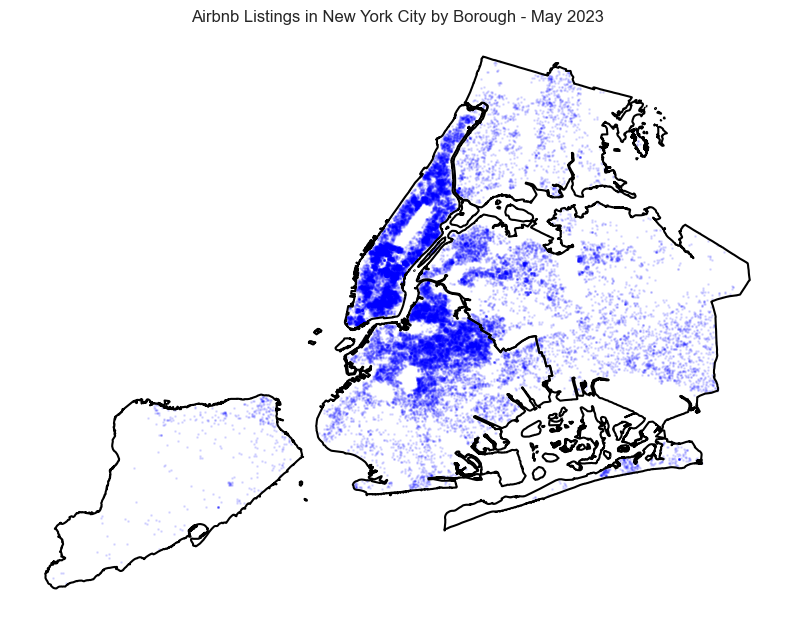

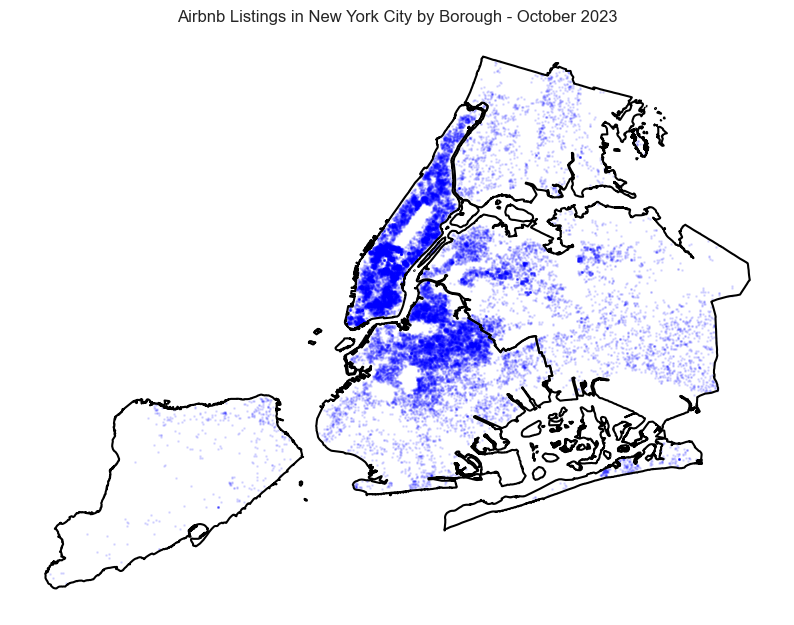

In [54]:


def plot_listings_by_borough(data, month):
    """
    Plot Airbnb listings on a map segmented by borough boundaries for a given month.
    """
    # Load New York City borough boundaries
    nyc_boroughs = gpd.read_file(gpd.datasets.get_path('nybb'))
    nyc_boroughs = nyc_boroughs.to_crs(epsg=4326)  # Convert to latitude/longitude
    
    # Convert DataFrame to GeoDataFrame with Point geometry
    geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
    gdf = gpd.GeoDataFrame(data, geometry=geometry)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    nyc_boroughs.boundary.plot(ax=ax, color='black')
    gdf.plot(ax=ax, markersize=1, color='blue', alpha=0.1, label='Listings')
    ax.set_title(f'Airbnb Listings in New York City by Borough - {month} 2023')
    ax.set_axis_off()

    plt.show()

# Plot listings by borough for May and October
plot_listings_by_borough(datasets['May'], 'May')
plot_listings_by_borough(datasets['October'], 'October')


In [55]:
# reload datasets for each month
files = [
    "data-listings-detailed/listings_detailed_202305.csv",
    "data-listings-detailed/listings_detailed_202306.csv",
    "data-listings-detailed/listings_detailed_202307.csv",
    "data-listings-detailed/listings_detailed_202308.csv",
    "data-listings-detailed/listings_detailed_202309.csv",
    "data-listings-detailed/listings_detailed_202310.csv"
]

# Read the files into dataframes
dfs = [pd.read_csv(path) for path in files]

# Merge the dataframes and add a column to identify the month
for i, df in enumerate(dfs):
    df['month'] = i + 5  # Months start from May (5)
all_data = pd.concat(dfs, ignore_index=True)

# Display basic information and the first few rows of the merged dataframe
all_data.shape

(252425, 76)

In [56]:
# Drop columns with all missing values
all_data.drop(columns=['bathrooms', 'calendar_updated'], inplace=True)

# Fill missing values for review-related columns with appropriate defaults
review_cols = ['review_scores_location', 'review_scores_value', 'review_scores_checkin',
               'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness',
               'review_scores_rating', 'reviews_per_month']

# fill with mean to neutralize the effect of outliers
for col in review_cols:
    all_data[col].fillna(all_data[col].mean(), inplace=True)
    

# Convert price column to float after removing dollar signs and commas
all_data['price'] = all_data['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Check the dataframe after cleaning
all_data.head()


id                                      listing_url  \
0            52582634            https://www.airbnb.com/rooms/52582634   
1  770290214254588951  https://www.airbnb.com/rooms/770290214254588951   
2  839233785270413877  https://www.airbnb.com/rooms/839233785270413877   
3  803382479124958259  https://www.airbnb.com/rooms/803382479124958259   
4             6221877             https://www.airbnb.com/rooms/6221877   

        scrape_id last_scraped       source  \
0  20230503161826   2023-05-03  city scrape   
1  20230503161826   2023-05-03  city scrape   
2  20230503161826   2023-05-10  city scrape   
3  20230503161826   2023-05-10  city scrape   
4  20230503161826   2023-05-10  city scrape   

                                                name  \
0  New Boho Modern 3Bd Entire Unit -20 Min- Manha...   
1      UBS Suites - Entire Home JFK/LGA/Belmont Park   
2  Home in Queens · ★New · 1 bedroom · 2 beds · 1...   
3  Rental unit in The Bronx · 2 bedrooms · 3 beds...   
4  Townhouse in Brooklyn · ★4.91 · 1 bedroom · 1 ...   

                                         description  \
0  Are you visiting NYC and can't find a place to...   
1  Welcome to UBS Suites. This entire home is equ...   
2  Forget your worries in this spacious and seren...   
3  Desconecta de tus preocupaciones en este espac...   
4  Enjoy high-quality life and feel at ease in Br...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Our house is very conveniently located on a tr...   

                                         picture_url    host_id  ...  \
0  https://a0.muscache.com/pictures/miso/Hosting-...  418115272  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...   11855341  ...   
2  https://a0.muscache.com/pictures/miso/Hosting-...  335040889  ...   
3  https://a0.muscache.com/pictures/miso/Hosting-...  373584750  ...   
4  https://a0.muscache.com/pictures/77573065/07c7...   31675601  ...   

  review_scores_location review_scores_value license instant_bookable  \
0               4.880000            4.670000     NaN                t   
1               4.950000            4.950000     NaN                f   
2               4.726442            4.632962     NaN                f   
3               4.726442            4.632962     NaN                t   
4               4.870000            4.880000     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              3                                           3   
1                              1                                           1   
2                              2                                           1   
3                              1                                           0   
4                              4                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            1   
3                                            1   
4                                            4   

  calculated_host_listings_count_shared_rooms reviews_per_month month  
0                                           0          1.260000     5  
1                                           0          4.160000     5  
2                                           0          1.176762     5  
3                                           0          1.176762     5  
4                                           0          0.720000     5  

[5 rows x 74 columns]

In [57]:
# Extract month from 'last_scraped' column for volume analysis
all_data['month'] = pd.to_datetime(all_data['last_scraped']).dt.month

# Count unique listings for each month
monthly_volume = all_data.groupby('month')['id'].nunique()

monthly_volume


month
5     43303
6     43566
7     43729
8     43582
9     39453
10    38792
Name: id, dtype: int64

In [58]:
# Filter listings that accommodate more than two guests
more_than_two_guests = all_data[all_data['accommodates'] > 2]

# Count such listings for each month
monthly_guest_capacity = more_than_two_guests.groupby('month')['id'].nunique()


monthly_guest_capacity


month
5     17157
6     17212
7     17288
8     17262
9     15305
10    14702
Name: id, dtype: int64

In [59]:
# Count listings based on room type for each month
room_type_counts = all_data.groupby(['month', 'room_type'])['id'].nunique().unstack()

room_type_counts


room_type  Entire home/apt  Hotel room  Private room  Shared room
month                                                            
5                    24537         180         18020          566
6                    24649         151         18186          580
7                    24722         150         18309          548
8                    24649         135         18259          539
9                    21981         133         16841          498
10                   21319         132         16849          492

In [60]:
# Calculate average price for each month
average_price_per_month = all_data.groupby('month')['price'].mean()

# round the values to 2 decimal places
average_price_per_month = average_price_per_month.round(2)

average_price_per_month


month
5     216.10
6     225.22
7     217.07
8     212.09
9     219.15
10    215.95
Name: price, dtype: float64

In [61]:
# Calculate average price for each month and room type

average_price_per_month_and_room_type = all_data.groupby(['month', 'room_type'])['price'].mean().unstack()

# round the values to 2 decimal places
average_price_per_month_and_room_type = average_price_per_month_and_room_type.round(2)


average_price_per_month_and_room_type

room_type  Entire home/apt  Hotel room  Private room  Shared room
month                                                            
5                   265.18      397.44        150.28       126.38
6                   273.37      483.62        160.97       125.87
7                   269.29      366.42        147.93       130.23
8                   266.52      433.35        139.42       129.74
9                   263.85      552.17        160.71       133.81
10                  262.53      559.93        156.34       146.43

## Guest Capacity check

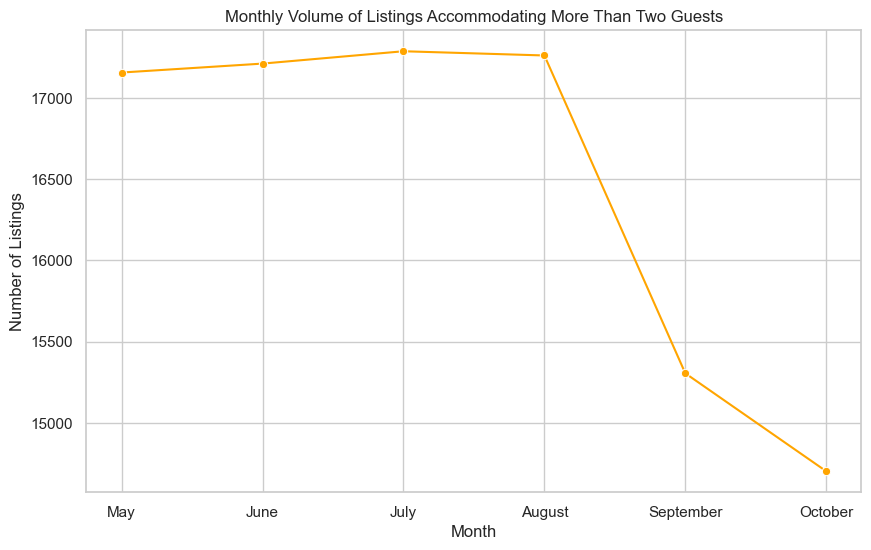

In [62]:
# Guest Capacity Analysis Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_guest_capacity.index, y=monthly_guest_capacity.values, marker='o', color='orange')
plt.title('Monthly Volume of Listings Accommodating More Than Two Guests')
plt.xlabel('Month')
plt.ylabel('Number of Listings')
plt.xticks(monthly_guest_capacity.index, ['May', 'June', 'July', 'August', 'September', 'October'])
plt.show()


<Figure size 1200x800 with 0 Axes>

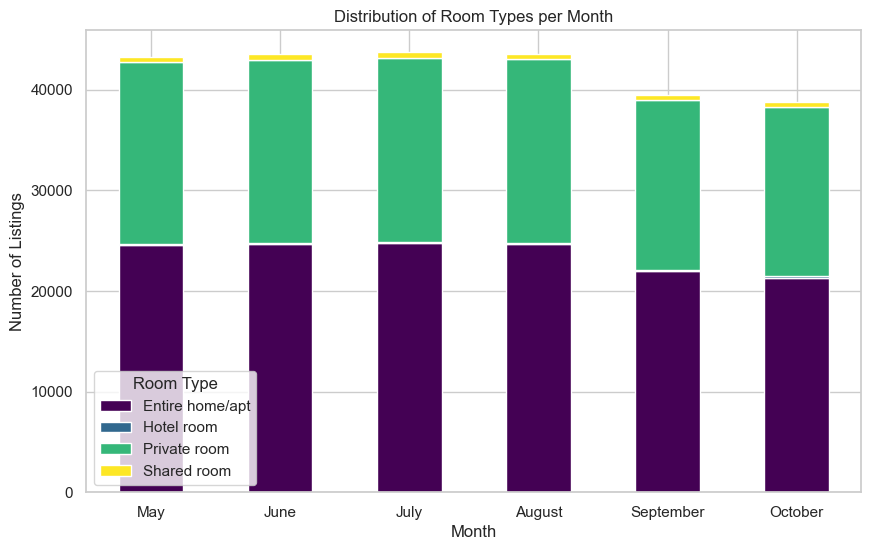

In [63]:
# Room Type Analysis Visualization
plt.figure(figsize=(12, 8))
room_type_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Distribution of Room Types per Month')
plt.xlabel('Month')
plt.ylabel('Number of Listings')
plt.xticks(ticks=range(6), labels=['May', 'June', 'July', 'August', 'September', 'October'], rotation=0)
plt.legend(title='Room Type')
plt.show()


## min nights check

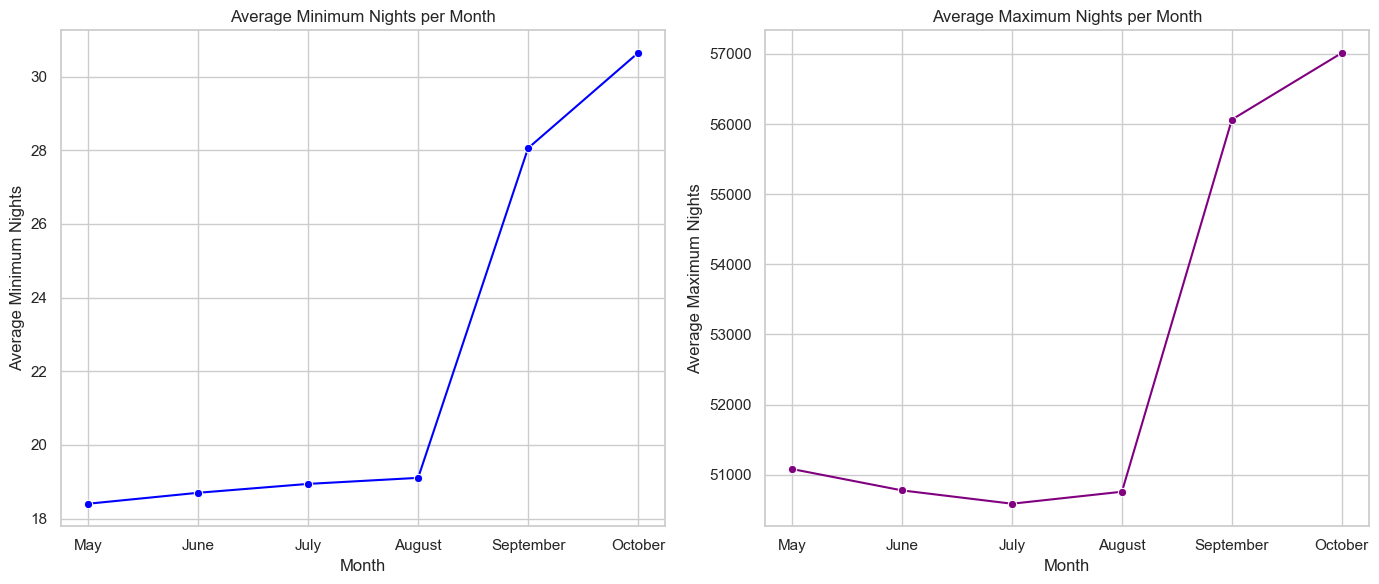

In [64]:
# Analysis of minimum_nights and maximum_nights
average_minimum_nights_per_month = all_data.groupby('month')['minimum_nights'].mean()
average_maximum_nights_per_month = all_data.groupby('month')['maximum_nights'].mean()

# Visualization for minimum_nights and maximum_nights
plt.figure(figsize=(14, 6))

# Minimum Nights
plt.subplot(1, 2, 1)
sns.lineplot(x=average_minimum_nights_per_month.index, y=average_minimum_nights_per_month.values, marker='o', color='blue')
plt.title('Average Minimum Nights per Month')
plt.xlabel('Month')
plt.ylabel('Average Minimum Nights')
plt.xticks(average_minimum_nights_per_month.index, ['May', 'June', 'July', 'August', 'September', 'October'])

# Maximum Nights
plt.subplot(1, 2, 2)
sns.lineplot(x=average_maximum_nights_per_month.index, y=average_maximum_nights_per_month.values, marker='o', color='purple')
plt.title('Average Maximum Nights per Month')
plt.xlabel('Month')
plt.ylabel('Average Maximum Nights')
plt.xticks(average_maximum_nights_per_month.index, ['May', 'June', 'July', 'August', 'September', 'October'])

plt.tight_layout()
plt.show()


## room type price shift

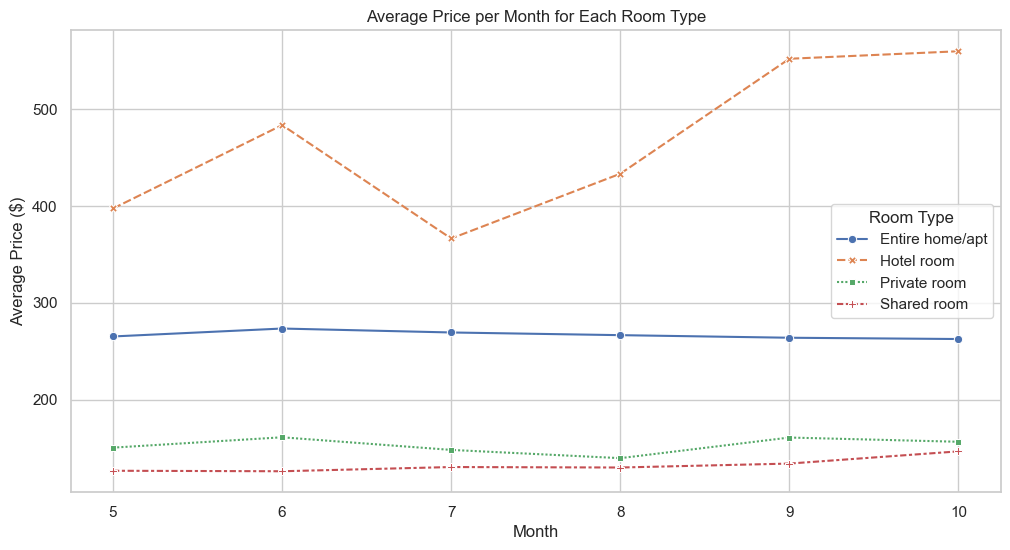

In [65]:
# Calculate the average price per month for each room type
average_price_per_month_room_type = all_data.groupby(['month', 'room_type'])['price'].mean().unstack()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_price_per_month_room_type, markers=True)
plt.title('Average Price per Month for Each Room Type')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.legend(title='Room Type')
plt.show()


hotel type raises up significantly. possibilly due to the law impact that short term rental is not allowed and return to hotel type of booking.

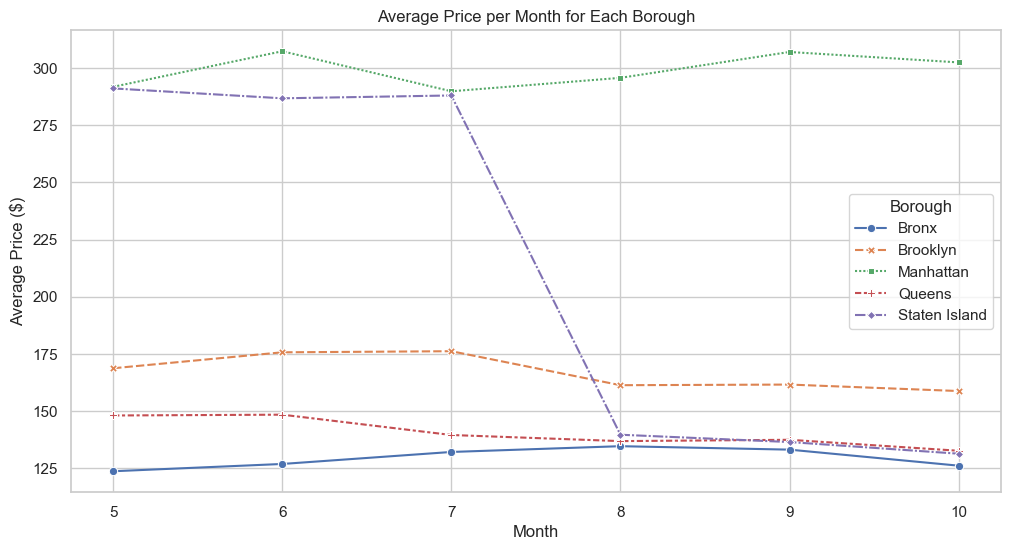

In [66]:
# Calculate the average price per month for each neighborhood group (borough)
average_price_per_month_borough = all_data.groupby(['month', 'neighbourhood_group_cleansed'])['price'].mean().unstack()

# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_price_per_month_borough, markers=True)
plt.title('Average Price per Month for Each Borough')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.legend(title='Borough')
plt.show()


In [67]:
# reload datasets for each month

file = [
    "data-listings-detailed/listings_detailed_202305.csv",
    "data-listings-detailed/listings_detailed_202306.csv",
    "data-listings-detailed/listings_detailed_202307.csv",
    "data-listings-detailed/listings_detailed_202308.csv",
    "data-listings-detailed/listings_detailed_202309.csv",
    "data-listings-detailed/listings_detailed_202310.csv"
]

files = {
    "May_2023": file[0],
    "June_2023": file[1],
    "July_2023": file[2],
    "August_2023": file[3],
    "September_2023": file[4],
    "October_2023": file[5]
}

# combine all the dataframes into a single dictionary
dataframes = {month: pd.read_csv(filepath) for month, filepath in files.items()}
dataframes["May_2023"].shape


(43303, 75)

In [68]:
# preprocessing the data
for month, df in dataframes.items():
    # host_response_time
    # Filling missing values with "unknown" for host_response_time
    df['host_response_time'] = df['host_response_time'].fillna('unknown')

    # host_is_superhost
    # Converting host_is_superhost to boolean
    df['host_is_superhost'] = df['host_is_superhost'].map({'t': True, 'f': False})
    # filling missing values with False
    df['host_is_superhost'] = df['host_is_superhost'].fillna(False)
    
    # price
    # Removing dollar signs and commas from price strings, then converting to float
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    
    # host_response_rate
    # Removing percent signs from host_response_rate strings, then converting to float
    df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
    
    # filling missing values with 0
    df['host_listings_count'] = df['host_listings_count'].fillna(0)
    df['host_total_listings_count'] = df['host_total_listings_count'].fillna(0)
    df['availability_30'] = df['availability_30'].fillna(0)
    df['availability_60'] = df['availability_60'].fillna(0)
    df['availability_90'] = df['availability_90'].fillna(0)
    df['availability_365'] = df['availability_365'].fillna(0)
    


In [69]:
# Extracting the number of listings and average price for each month
listings_summary = {}

for month, df in dataframes.items():
    listings_count = df.shape[0]
    # Removing dollar signs and commas from price strings, then converting to float
    avg_price = df['price'].replace('[\$,]', '', regex=True).astype(float).mean()
    listings_summary[month] = {
        "Number of Listings": listings_count,
        "Average Price": avg_price
    }

listings_summary_df = pd.DataFrame.from_dict(listings_summary, orient='index')
listings_summary_df


Number of Listings  Average Price
May_2023                     43303     216.099574
June_2023                    43566     225.216109
July_2023                    43729     217.068399
August_2023                  43582     212.093640
September_2023               39453     219.153651
October_2023                 38792     215.945891

In [70]:
# Descriptive Statistics: Comparing average prices, number of listings, and host response rates before and after September 5

# Extracting necessary columns for analysis
columns_of_interest = [
    "price", "host_response_time", "host_response_rate",
    "availability_30", "availability_60", "availability_90", "availability_365",
    "host_listings_count", "host_total_listings_count", "host_is_superhost"
]

# Creating a dataframe with the necessary columns for each month
filtered_dataframes = {month: df[columns_of_interest] for month, df in dataframes.items()}


# Separating data into before and after September 5, 2023
before_law = pd.concat([filtered_dataframes["May_2023"], filtered_dataframes["June_2023"],
                        filtered_dataframes["July_2023"], filtered_dataframes["August_2023"]])

after_law = pd.concat([filtered_dataframes["September_2023"], filtered_dataframes["October_2023"]])

# Calculating descriptive statistics for before and after the law
descriptive_stats_before = before_law.describe(include='all')
descriptive_stats_after = after_law.describe(include='all')

# Removing unnecessary columns
descriptive_stats_before.drop(['count', 'unique', 'top', 'freq'], inplace=True)
descriptive_stats_after.drop(['count', 'unique', 'top', 'freq'], inplace=True)

# Extracting only the mean values for each feature
mean_stats_before = descriptive_stats_before.loc['mean']
mean_stats_after = descriptive_stats_after.loc['mean']

# Combining mean values into a single DataFrame
combined_mean_stats = pd.DataFrame({'Before Law': mean_stats_before, 'After Law': mean_stats_after})

# update host_response_time for before and after law
# Calculating the percentage of hosts that responded within an hour before and after the law
rate_before = before_law['host_response_time'].value_counts(normalize=True)['within an hour']
rate_after = after_law['host_response_time'].value_counts(normalize=True)['within an hour']

combined_mean_stats.loc['host_response_time'] = [rate_before, rate_after]

# rename index to "host_response_time_within_an_hour"
combined_mean_stats.rename(index={'host_response_time': 'host_response_time_within_an_hour'}, inplace=True)

# update host_is_superhost for before and after law

# Calculating the percentage of hosts that were superhosts before and after the law
superhost_before = before_law['host_is_superhost'].value_counts(normalize=True)[True]
superhost_after = after_law['host_is_superhost'].value_counts(normalize=True)[True]

combined_mean_stats.loc['host_is_superhost'] = [superhost_before, superhost_after]



combined_mean_stats

Before Law   After Law
price                              217.620702   217.56332
host_response_time_within_an_hour    0.423614     0.42643
host_response_rate                   92.81105   92.579598
availability_30                      7.412694    7.177762
availability_60                     17.812292   18.215771
availability_90                     29.789362   31.566477
availability_365                   137.475692  146.750617
host_listings_count                120.151768  140.039657
host_total_listings_count          187.924469  226.835414
host_is_superhost                    0.163917    0.206147

In [71]:
# Filtering short-term rentals based on 'minimum_nights' (assuming listings with minimum nights < 30 are short-term)
short_term_rentals = {}

for month, df in dataframes.items():
    if 'minimum_nights' in df.columns:
        short_term_df = df[df['minimum_nights'] < 30]
        short_term_rentals[month] = short_term_df

# Analyzing the presence of registration numbers in short-term rentals after the law
short_term_registration_stats = {}

for month, df in short_term_rentals.items():
    if month in ['July_2023','August_2023', 'September_2023', 'October_2023']:
        total_listings = df.shape[0]
        with_registration = df['license'].notna().sum()
        short_term_registration_stats[month] = {
            "Total Short-term Listings": total_listings,
            "With Registration": with_registration,
            "Without Registration": total_listings - with_registration
        }

short_term_registration_stats_df = pd.DataFrame.from_dict(short_term_registration_stats, orient='index')
short_term_registration_stats_df


Total Short-term Listings  With Registration  \
July_2023                           22146                  0   
August_2023                         21785                  0   
September_2023                       6841                  0   
October_2023                         3227               2785   

                Without Registration  
July_2023                      22146  
August_2023                    21785  
September_2023                  6841  
October_2023                     442

## Binary Classification Model for Compliance

In [72]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Adding 'minimum_nights' to the columns of interest
compliance_model_columns_extended = ['accommodates', 'license', 'minimum_nights']

# Combining datasets from all months and selecting relevant columns for the extended compliance model
combined_compliance_extended_df = pd.concat([df[compliance_model_columns_extended] for df in dataframes.values()])

# Defining the target variable for compliance
combined_compliance_extended_df['is_compliant'] = np.where(
    (combined_compliance_extended_df['accommodates'] <= 2) & 
    (combined_compliance_extended_df['license'].notna()) & 
    (combined_compliance_extended_df['minimum_nights'] >= 30)
    , 1, 0
)

#

# Dropping the original columns used to derive the target
combined_compliance_extended_df.drop(['accommodates', 'license'], axis=1, inplace=True)

# Addressing class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
X = combined_compliance_extended_df.drop('is_compliant', axis=1)
y = combined_compliance_extended_df['is_compliant']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Training a RandomForestClassifier model
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = classifier.predict(X_test)

# Calculating evaluation metrics
classification_report_res = classification_report(y_test, y_pred)
roc_auc_score_res = roc_auc_score(y_test, y_pred)

# calculate the f1 score




classification_report_res, roc_auc_score_res, f1_score(y_test, y_pred)


('              precision    recall  f1-score   support\n\n           0       1.00      0.44      0.61     50556\n           1       0.64      1.00      0.78     50384\n\n    accuracy                           0.72    100940\n   macro avg       0.82      0.72      0.70    100940\nweighted avg       0.82      0.72      0.70    100940\n',
 0.7195555045235816,
 0.7800939928342098)

In [73]:
# reload datasets for each month

file = [
    "data-listings-detailed/listings_detailed_202305.csv",
    "data-listings-detailed/listings_detailed_202306.csv",
    "data-listings-detailed/listings_detailed_202307.csv",
    "data-listings-detailed/listings_detailed_202308.csv",
    "data-listings-detailed/listings_detailed_202309.csv",
    "data-listings-detailed/listings_detailed_202310.csv"
]

# Re-loading the data from each CSV file
datasets = {}
for file_path in file:
    month = file_path.split("_")[2][:-4]
    print(month)
    datasets[month] = pd.read_csv(file_path)

datasets['202305'].shape


202305
202306
202307
202308
202309
202310


(43303, 75)

## association rule mining / market segmentation

In [74]:
# drop price greater than 1000

for month, df in datasets.items():
    # pre-processing price
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

    # drop price greater than 1000
    df.drop(df[df['price'] > 1000].index, inplace=True)

    # drop price less than 10
    df.drop(df[df['price'] < 10].index, inplace=True)



In [75]:
# Combining the datasets from pre-law months (May, June, July, August)
pre_law_data = pd.concat([datasets['202307'], datasets['202308']], ignore_index=True)

# Combining the datasets from post-law months (September, October)
post_law_data = pd.concat([datasets['202309'], datasets['202310']], ignore_index=True)

# Checking the shape of the combined datasets
pre_law_data.shape, post_law_data.shape


((85816, 75), (76902, 75))

can plug in other features to see the association

In [76]:
# Function to perform basic association rule mining 
def basic_association_rule_mining(data):
    # Selecting relevant features for association rule mining
    selected_features = data[['neighbourhood_cleansed', 'room_type']]
    selected_features['price_range'] = pd.qcut(data['price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

    # Counting combinations of features
    combinations_count = selected_features.groupby(['neighbourhood_cleansed', 'room_type', 'price_range']).size().reset_index(name='count')
    combinations_count = combinations_count.sort_values(by='count', ascending=False)

    return combinations_count

# Performing basic association rule mining for pre-law dataset
pre_law_combinations = basic_association_rule_mining(pre_law_data)

# Performing basic association rule mining for post-law dataset
post_law_combinations = basic_association_rule_mining(post_law_data)

In [77]:
# Displaying the top 10 combinations for pre law

pre_law_combinations.sort_values('count', ascending=False).head(10)

neighbourhood_cleansed        room_type price_range  count
200      Bedford-Stuyvesant     Private room         Low   2212
440                Bushwick     Private room         Low   1692
2067                Midtown  Entire home/apt   Very High   1544
194      Bedford-Stuyvesant  Entire home/apt        High   1345
1555         Hell's Kitchen  Entire home/apt   Very High   1267
1544                 Harlem     Private room         Low   1209
3459           Williamsburg  Entire home/apt   Very High   1204
3464           Williamsburg     Private room         Low   1159
3458           Williamsburg  Entire home/apt        High   1126
3267        Upper West Side  Entire home/apt   Very High   1077

In [78]:
# Displaying the top 10 combinations for post law

post_law_combinations.sort_values('count', ascending=False).head(10)

neighbourhood_cleansed        room_type price_range  count
200      Bedford-Stuyvesant     Private room         Low   2028
440                Bushwick     Private room         Low   1596
2067                Midtown  Entire home/apt   Very High   1441
1555         Hell's Kitchen  Entire home/apt   Very High   1141
3250        Upper East Side  Entire home/apt        High   1120
194      Bedford-Stuyvesant  Entire home/apt        High   1040
1544                 Harlem     Private room         Low   1018
3458           Williamsburg  Entire home/apt        High   1013
3464           Williamsburg     Private room         Low    991
3267        Upper West Side  Entire home/apt   Very High    920

october 2023

In [79]:
# Isolating the dataset for October 2023
october_data = datasets['202310']

# Checking the shape of the October dataset
october_data.shape


(38134, 75)

In [80]:
# Creating a derived 'compliance_status' column based on the 'accommodates' criterion for the October dataset
october_data['compliance_status'] = october_data['accommodates'].apply(lambda x: 'Non-Compliant' if x > 2 else 'Compliant')

# Checking the distribution of the compliance status in the October dataset
october_data['compliance_status'].value_counts()


compliance_status
Compliant        23994
Non-Compliant    14140
Name: count, dtype: int64

In [81]:
october_data.license.value_counts()

license
Exempt                2246
OSE-STRREG-0000068     107
OSE-STRREG-0000437       7
OSE-STRREG-0008664       6
OSE-STRREG-0000207       4
                      ... 
OSE-STRREG-1078654       1
OSE-STRREG-0000411       1
OSE-STRREG-0000205       1
OSE-STRREG-0001124       1
OSE-STRREG-0000289       1
Name: count, Length: 274, dtype: int64

In [82]:
# subset october_data to only include listings with license

october_data_with_license = october_data[october_data['license'].notna()]

october_data_with_license.shape


(2676, 76)

In [83]:
october_data_with_license.accommodates.value_counts()

accommodates
2     1310
4      542
6      180
3      130
8      128
5      123
1       80
12      80
7       35
16      27
10      24
9        7
14       6
15       4
Name: count, dtype: int64

In [84]:
# subset october data without license

october_data_without_license = october_data[october_data['license'].isna()]



In [85]:
october_data_without_license.accommodates.value_counts()

accommodates
2     15939
1      6665
4      5231
3      3336
6      1666
5      1333
8       532
7       322
10      161
12       82
16       65
9        60
11       23
15       20
13       12
14       11
Name: count, dtype: int64

## potentially compliant listings vs potentially non-compliant listings

In [86]:
# Extracting the dataset for October 2023
october_data = datasets['202310']

# pre-processing price
october_data['price'] = october_data['price'].replace('[\$,]', '', regex=True).astype(float)

# drop price greater than 1000
october_data.drop(october_data[october_data['price'] > 1000].index, inplace=True)

# drop price less than 10
october_data.drop(october_data[october_data['price'] < 10].index, inplace=True)

# Creating a derived 'compliance_status' column based on the 'accommodates' criterion for the October dataset
october_data['compliance_status'] = october_data['accommodates'].apply(lambda x: 'Non-Compliant' if x > 2 else 'Compliant')


# Function to perform basic association rule mining using available tools
def basic_association_rule_mining(data, compliance_status):
    # Filtering the data based on compliance status
    filtered_data = data[data['compliance_status'] == compliance_status]

    # Selecting relevant features for association rule mining
    selected_features = filtered_data[['neighbourhood_cleansed', 'room_type']]
    selected_features['price_range'] = pd.qcut(filtered_data['price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

    # Counting combinations of features
    combinations_count = selected_features.groupby(['neighbourhood_cleansed', 'room_type', 'price_range']).size().reset_index(name='count')
    combinations_count = combinations_count.sort_values(by='count', ascending=False)

    return combinations_count


In [87]:
# Performing basic association rule mining for potentially compliant listings in October 2023
compliant_combinations_october = basic_association_rule_mining(october_data, 'Compliant')

# Performing basic association rule mining for potentially non-compliant listings in October 2023
non_compliant_combinations_october = basic_association_rule_mining(october_data, 'Non-Compliant')

# Displaying the top 10 combinations for each category
compliant_combinations_october.head(10)

neighbourhood_cleansed        room_type price_range  count
200      Bedford-Stuyvesant     Private room         Low    772
440                Bushwick     Private room         Low    600
3385           Williamsburg     Private room      Medium    394
201      Bedford-Stuyvesant     Private room      Medium    379
1513                 Harlem     Private room      Medium    362
3379           Williamsburg  Entire home/apt   Very High    350
2035                Midtown  Entire home/apt   Very High    342
840           Crown Heights     Private room         Low    292
441                Bushwick     Private room      Medium    290
1512                 Harlem     Private room         Low    284

In [88]:
non_compliant_combinations_october.head(10)

neighbourhood_cleansed        room_type price_range  count
1971                Midtown  Entire home/apt   Very High    312
1970                Midtown  Entire home/apt        High    277
1507         Hell's Kitchen  Entire home/apt   Very High    261
3121        Upper East Side  Entire home/apt      Medium    246
193      Bedford-Stuyvesant  Entire home/apt      Medium    245
194      Bedford-Stuyvesant  Entire home/apt        High    196
192      Bedford-Stuyvesant  Entire home/apt         Low    196
1506         Hell's Kitchen  Entire home/apt        High    192
3139        Upper West Side  Entire home/apt   Very High    188
1505         Hell's Kitchen  Entire home/apt      Medium    183

## text mining on listing information

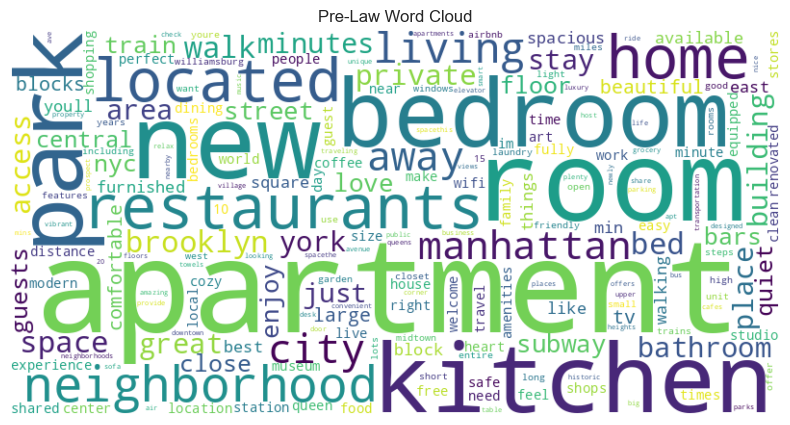

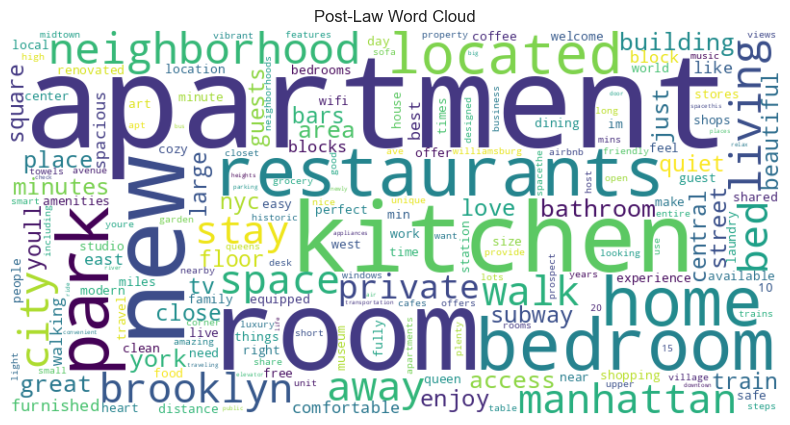

In [89]:
# Data Preparation: Extracting and cleaning text data
def extract_clean_text_data(data):
    # Extracting relevant columns
    text_data = data[['description', 'host_about', 'neighborhood_overview']].fillna("")

    # Concatenating the text columns into a single text per listing
    text_data['combined_text'] = text_data['description'] + " " + text_data['host_about'] + " " + text_data['neighborhood_overview']

    # Cleaning the text data
    text_data['combined_text'] = text_data['combined_text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Removing URLs
    text_data['combined_text'] = text_data['combined_text'].str.replace(r'http\S+', '', regex=True).str.strip()
    
    # Removing HTML tags
    text_data['combined_text'] = text_data['combined_text'].str.replace(r'<.*?>', '', regex=True).str.strip()
    
    # Removing non-alphanumeric characters
    text_data['combined_text'] = text_data['combined_text'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True).str.strip()
    
    # Converting to lowercase
    text_data['combined_text'] = text_data['combined_text'].str.lower()
    

    return text_data['combined_text']

# Extracting and cleaning text data for pre-law period
pre_law_text_data = extract_clean_text_data(pd.concat([datasets['202305'], datasets['202306'], datasets['202307'], datasets['202308']], ignore_index=True))

# Extracting and cleaning text data for post-law period
post_law_text_data = extract_clean_text_data(pd.concat([datasets['202309'], datasets['202310']], ignore_index=True))

# Displaying the first few entries of cleaned text data for each period
# pre_law_text_data.head(), post_law_text_data.head()


# Function to create word clouds for visualizing word frequency
def create_word_cloud(text_data, title):
    # Using CountVectorizer to extract word frequencies
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(text_data)
    word_counts_sum = word_counts.sum(axis=0)
    words_freq = [(word, word_counts_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Generating a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq))

    # Displaying the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Creating word clouds for pre-law and post-law text data
create_word_cloud(pre_law_text_data, "Pre-Law Word Cloud")
create_word_cloud(post_law_text_data, "Post-Law Word Cloud")



the word clouds suggest not much difference between pre and post law.


In [91]:


# Function to calculate average sentiment of text data
def calculate_average_sentiment(text_data):
    sentiments = [TextBlob(text).sentiment.polarity for text in text_data]
    average_sentiment = sum(sentiments) / len(sentiments)
    return average_sentiment

# Calculating average sentiment for pre-law and post-law text data
pre_law_average_sentiment = calculate_average_sentiment(pre_law_text_data)
post_law_average_sentiment = calculate_average_sentiment(post_law_text_data)

# Displaying the average sentiment for each period
pre_law_average_sentiment, post_law_average_sentiment


(0.251421001074319, 0.2527621920408557)

Both pre-law and post-law periods have a similar average sentiment, hovering around 0.25, which suggests a generally positive tone in the listings' descriptions.
There is a very slight change is, minimal.

## neighborhoods with the most significant increases and decreases

In [92]:
# Grouping data by neighborhood to calculate the density of listings
def calculate_neighborhood_density(data):
    return data.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Calculating neighborhood density for pre-law and post-law periods
pre_law_density = calculate_neighborhood_density(pd.concat([datasets['202307'], datasets['202308']], ignore_index=True))
post_law_density = calculate_neighborhood_density(pd.concat([datasets['202309'], datasets['202310']], ignore_index=True))

# Merging the two dataframes to compute the difference in listing density
density_difference = pre_law_density.merge(post_law_density, on='neighbourhood_cleansed', how='outer', suffixes=('_pre', '_post'))
density_difference.fillna(0, inplace=True)
density_difference['density_change'] = density_difference['listing_count_post'] - density_difference['listing_count_pre']

# Sorting neighborhoods by change in listing density
density_difference = density_difference.sort_values(by='density_change', ascending=False)

# Displaying neighborhoods with the most significant changes in listing density
# density_difference.head(10), density_difference.tail(10)


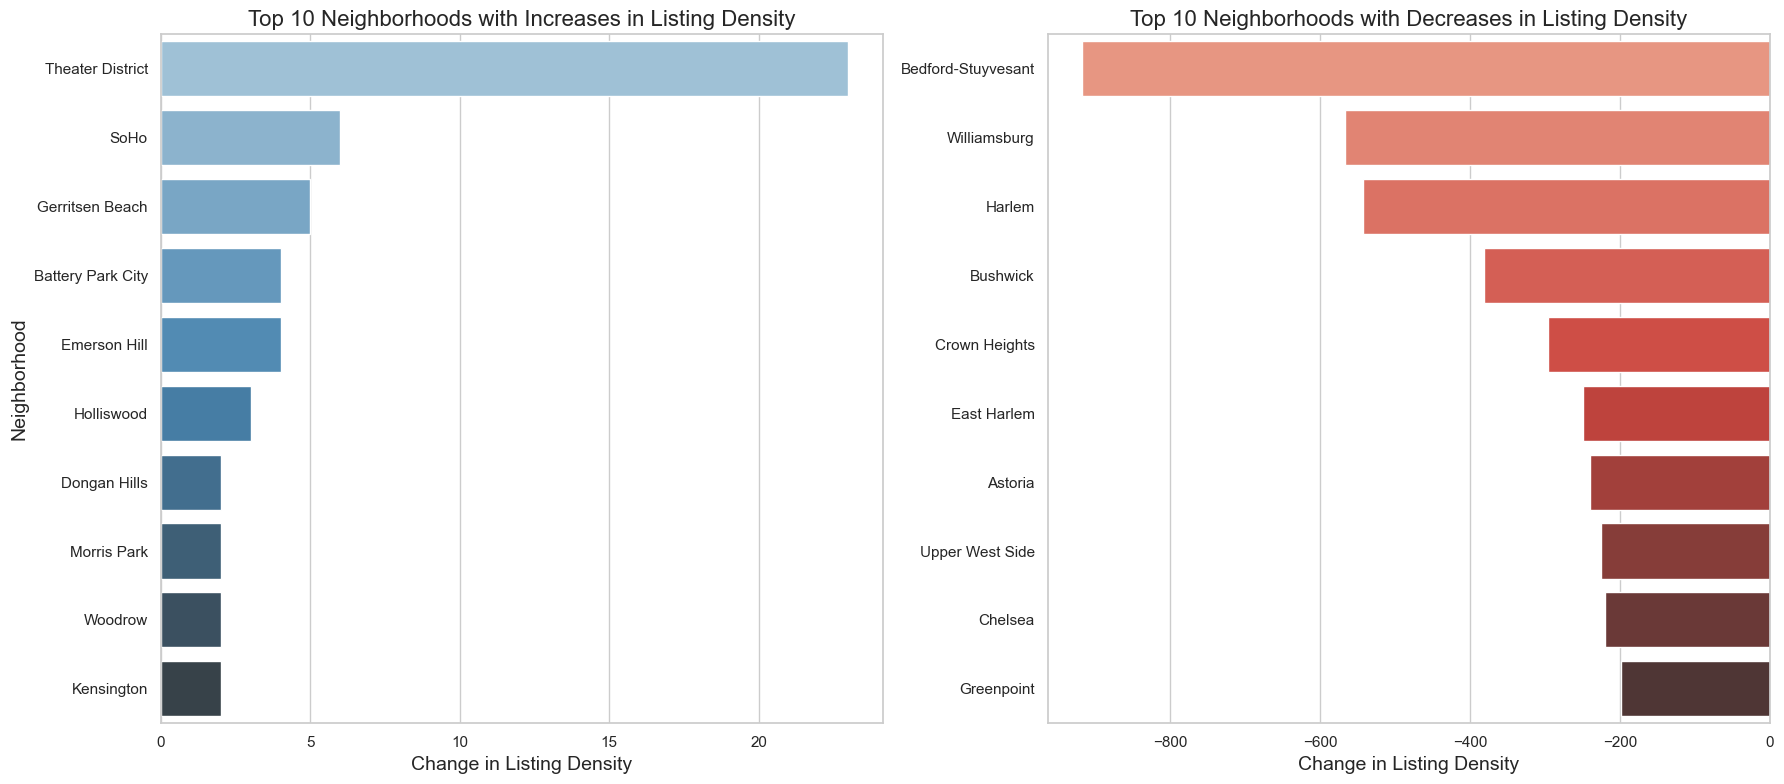

In [93]:

# Selecting top 10 neighborhoods with the most significant increases and decreases in listing density
top_increases = density_difference.nlargest(10, 'density_change')
top_decreases = density_difference.nsmallest(10, 'density_change')

# Plotting the changes in listing density
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot for neighborhoods with the most significant increases
sns.barplot(data=top_increases, x='density_change', y='neighbourhood_cleansed', ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 10 Neighborhoods with Increases in Listing Density', fontsize=16)
axes[0].set_xlabel('Change in Listing Density', fontsize=14)
axes[0].set_ylabel('Neighborhood', fontsize=14)

# Plot for neighborhoods with the most significant decreases
sns.barplot(data=top_decreases, x='density_change', y='neighbourhood_cleansed', ax=axes[1], palette="Reds_d")
axes[1].set_title('Top 10 Neighborhoods with Decreases in Listing Density', fontsize=16)
axes[1].set_xlabel('Change in Listing Density', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()
